In [41]:
# !pip install folium
# !pip install matplotlib -U
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# 기본 설정 및 데이터 불러오기

1. library import

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap
from folium.features import DivIcon
from google.colab import drive
from google.colab import files
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams ['font.family']=['NanumGothic', 'sans-serif']
plt.rcParams['axes.unicode_minus']=False


2. 드라이브 마운트 및 csv파일 업로드

In [43]:
drive.mount('gdirve')


Drive already mounted at gdirve; to attempt to forcibly remount, call drive.mount("gdirve", force_remount=True).


3. csv 불러오기


In [44]:
filepath_2020_taxi = '/content/gdirve/MyDrive/lecture-2023-bigdata/merge_20.csv' #택시데이터
filepath_geocode = '/content/gdirve/MyDrive/lecture-2023-bigdata/icn_geocode2.csv' #동 별 대표 위경도 지오코딩 데이터
filepath_accident = '/content/gdirve/MyDrive/lecture-2023-bigdata/icn_accident.csv'#TASS사고데이터 통합

df_taxi = pd.read_csv(filepath_2020_taxi)
df_accident = pd.read_csv(filepath_accident)
df_geocode = pd.read_csv(filepath_geocode)


# 택시데이터에 그룹별 사고위험지수와 위경도데이터 합병

0. 택시데이터 운행속도가 1 이하인 것은 1로 처리

In [45]:
df_taxi.loc[df_taxi['운행속도'] <= 1, '운행속도'] = 1

1. 사고위험지수 계산

In [46]:
df_accident['사망자수'] = df_accident['사망자수'].astype('float').round(2)  # 1.0000
df_accident['중상자수'] = df_accident['중상자수'].astype('float').round(2) #0.1168
df_accident['경상자수'] = df_accident['경상자수'].astype('float').round(2) #0.0068
df_accident['부상신고자수'] = df_accident['부상신고자수'].astype('float').round(2) #0.0033

In [47]:
df_accident['위험도'] = ((df_accident['사망자수'] * 1.0) + (df_accident['중상자수'] * 0.1168) + (df_accident['경상자수'] * 0.0068) + (df_accident['부상신고자수'] * 0.0033)) * df_accident['갯수']
df_accident = df_accident.groupby(['동', '사고월', '요일', '구간'], as_index=False)['위험도'].sum()
df_accident = df_accident.rename(columns={'사고월': '월', '구간': '시간대'})


In [48]:
df_accident

,동,월,요일,시간대,위험도
0,가정동,1,0,0,0.006800
1,가정동,1,0,1,0.281132
2,가정동,1,0,2,0.397932
3,가정동,1,0,3,0.291164
4,가정동,1,0,4,0.872000
...,...,...,...,...,...
28509,효성동,12,6,0,0.281268
28510,효성동,12,6,1,0.254000
28511,효성동,12,6,2,0.144000
28512,효성동,12,6,3,1.137200


2. 택시데이터에 사고위험지수와 지오코딩 위경도 병합

In [49]:
df_taxi = pd.merge(df_taxi, df_accident[['요일', '월', '동', '시간대', '위험도']], on=['요일', '월', '동', '시간대'], how='left')
df_taxi = df_taxi.merge(df_geocode[['동', '위도', '경도']], on='동', how='left')
df_taxi

,요일,월,시간대,동,운행속도,위험도,위도,경도
0,0,1,0,가정동,24,0.0068,37.526332,126.670520
1,0,1,0,가좌동,25,1.3572,37.494372,126.672601
2,0,1,0,간석동,22,1.5579,37.460391,126.698042
3,0,1,0,갈산동,22,1.0340,37.517675,126.727199
4,0,1,0,갈현동,45,NaN,37.580800,126.722300
...,...,...,...,...,...,...,...,...
48901,6,12,4,항동4가,51,NaN,37.471381,126.620485
48902,6,12,4,항동7가,13,NaN,37.453810,126.602212
48903,6,12,4,화수동,5,NaN,37.485201,126.630825
48904,6,12,4,화평동,16,NaN,37.479000,126.630900


# 택시데이터의 위험도 결측값 회귀

## 1. 데이터셋 분할

In [50]:
import numpy as np
from sklearn.model_selection import train_test_split

df_taxi_set = df_taxi[~df_taxi['위험도'].isnull()]

X = df_taxi_set[['요일', '월', '시간대', '위도', '경도']]
y = df_taxi_set['위험도']

trainX, testX, trainy, testy = train_test_split(X, y, test_size=0.2, random_state=1)

print(trainX)
print(trainy)

       요일   월  시간대         위도          경도
5351    2   2    1  37.511185  126.674756
33397   1   9    2  37.474600  126.756100
7428    5   2    4  37.518394  126.737573
46798   3  12    1  37.391047  126.652035
35770   5   9    2  37.474600  126.756100
...    ..  ..  ...        ...         ...
19613   6   5    0  37.448775  126.731991
30792   3   8    4  37.519812  126.701964
9460    2   3    2  37.579200  126.670000
21791   2   6    3  37.476265  126.640256
419     0   1    3  37.548931  126.678211

[22024 rows x 5 columns]
5351     0.24040
33397    0.00680
7428     0.07803
46798    0.51460
35770    0.00680
          ...   
19613    0.27770
30792    0.23920
9460     0.00680
21791    0.24720
419      0.27440
Name: 위험도, Length: 22024, dtype: float64


## 2-1 AdaBoost Regressor

In [51]:
# from sklearn.ensemble import AdaBoostRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import accuracy_score
# from math import sqrt
# from sklearn.metrics import mean_squared_error

# tree_model = DecisionTreeRegressor(max_depth=1)
# clf = AdaBoostRegressor(base_estimator = tree_model, n_estimators=1000, random_state=0)
# clf.fit(trainX, trainy)
# predict = clf.predict(testX)
# print("RMSE: {}".format(sqrt(mean_squared_error(predict, testy))))

## 2-2 GradientBoost Regressor

In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from math import sqrt
from sklearn.metrics import mean_squared_error

clf = GradientBoostingRegressor(n_estimators=3000, random_state=0)
clf.fit(trainX, trainy)
predict = clf.predict(testX)
print("RMSE: {}".format(sqrt(mean_squared_error(predict, testy))))

RMSE: 0.3607951211538778


## 2-3 Bagging


In [53]:
# # 30 boots
# from sklearn.ensemble import BaggingRegressor
# from math import sqrt
# from sklearn.metrics import mean_squared_error
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.pipeline import make_pipeline

# regressor = LinearRegression()

# bagging_model  = BaggingRegressor(base_estimator = regressor, 
#                                   n_estimators = 1000,
#                                   verbose = 0
#                                   )
# clf = bagging_model.fit(trainX, trainy)
# predict = clf.predict(testX)
# print("RMSE: {}".format(sqrt(mean_squared_error(predict, testy))))

## 2-4 Random Forest

In [54]:
# from math import sqrt
# from sklearn.metrics import mean_squared_error
# from sklearn.ensemble import RandomForestRegressor

# clf = RandomForestRegressor(n_estimators=1000)

# clf.fit(trainX, trainy)
# predict = clf.predict(testX)
# print("RMSE: {}".format(sqrt(mean_squared_error(predict, testy))))

## 학습된 모델을 이용하여 위험도 결측값 채우기

In [55]:
df_taxi_set_nan = df_taxi[df_taxi['위험도'].isnull()]
df_taxi_set_nan_X = df_taxi_set_nan[['요일', '월', '시간대', '위도', '경도']]
predictions = clf.predict(df_taxi_set_nan_X)
df_taxi.loc[df_taxi['위험도'].isnull(), '위험도'] = predictions


음수로 예측된 결측값이 있다면 전체 데이터에 최소값(음수)을 뺌 
- 최소값은 0이 됨

In [56]:
if predictions.min() < 0 :
  df_taxi['위험도'] = df_taxi['위험도'] - predictions.min()

위험도 히스토그램 1차 확인. 분포가 매우 불균형함 확인

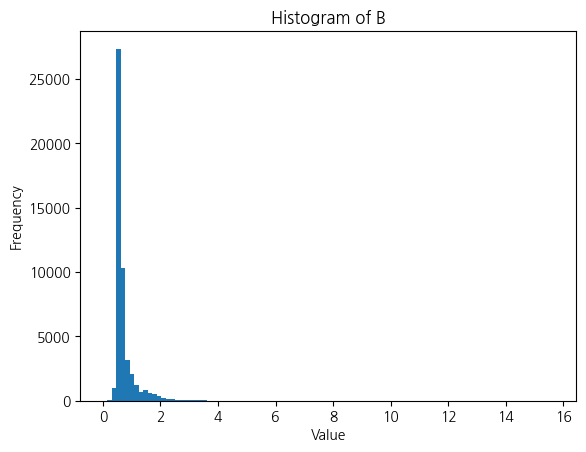

In [57]:
import matplotlib.pyplot as plt

plt.hist(df_taxi['위험도'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of B')
plt.show()


# 최종 위험지수 도출 수행
- 변수는 운행속도(A)와, 위험도(B). 둘 다 최종 위험지수(Y)와는 양의 상관관계를 가짐
- 유동차량수는 ~A 라고 하겠음
- 운행속도와 위험도를 단순 곱할수는 없으므로 임의의 상관관계를 지정했음
- [사망사고 3건, 유동차량 100대] Region1과 [사망사고 4건, 유동차량 200대]의 Region2의 최종 위험지수는 같다고 가설을 세움
  * == "B가 3인 지역 Region1과", "B가 4이면서 ~A가 Region1의 2배인 Region2"의 Y은 같다고 가설을 세움
- 어떤 운행속도에 대해서 유동차량이 2배가 되는 운행속도를 구하는 식은 아래에 따름
  * 운행속도대비유동차량.ipynb에 의해 도출
  * A' = 0.50 * A + 59.70 
- 위의 식을 이용하여 현재 운행속도를 기반으로, 위의 가설을 사용할 보정계수를 도출할 수 있음

### 위험도 보정계수 : (((3 / 2) * df_taxi['운행속도']) + ((59.7) * 3)) / (4 * df_taxi['운행속도'])

1. 보정계수 검증을 위한 테스트 데이터 생성

In [58]:
new_columns = ['요일', '월', '시간대', '동', '운행속도', '위험도', '위도', '경도']
new_data = [[0, 6, 1, '테스트동', 20, 4, 0, 0],
            [0, 7, 2, '테스트동', 69.7, 3, 0, 0],
            [0, 7, 2, '테스트동', 40, 4, 0, 0],
            [0, 7, 2, '테스트동', 79.7, 3, 0, 0],
            [0, 7, 2, '테스트동', 60.0, 4, 0, 0],
            [0, 7, 2, '테스트동', 89.7, 3, 0, 0],
            [0, 7, 2, '테스트동', 60.0, 8, 0, 0],
            [0, 7, 2, '테스트동', 89.7, 6, 0, 0],
            
            ]

# 새로운 열을 담은 데이터프레임 생성
new_df = pd.DataFrame(new_data, columns=new_columns)

# 기존 데이터프레임과 새로운 데이터프레임을 합치기
df_taxi = pd.concat([df_taxi, new_df], axis=0, ignore_index=True)

2. 보정계수와 위험도를 곱하여 Scaled된 위험도를 도출함

In [59]:
accident_bef_val = 3  #표본 사고지수
accident_after_val = 4  #표본에서 유동차량대수가 두배 늘었을 때 기준 사고지수

scaled_value = (((accident_bef_val / 2) * df_taxi['운행속도']) + ((59.7) * accident_bef_val)) / (accident_after_val * df_taxi['운행속도'])  #위험도 보정계수

df_taxi['위험도-Scaled'] = np.where(scaled_value <= 1, df_taxi['위험도'], df_taxi['위험도'] * scaled_value) #scaled_value는 1이상의 양수값에서 운행속도 120 근처로 소수 혹은 음수로 변환됨. 이 경우에는 보정계수를 1로 설정

df_taxi['운행속도-Scaled'] = df_taxi['운행속도']  #이건 의미없어짐. 그냥 그대로 추가된 컬럼
df_taxi

,요일,월,시간대,동,운행속도,위험도,위도,경도,위험도-Scaled,운행속도-Scaled
0,0,1,0,가정동,24.0,0.494396,37.526332,126.670520,1.107755,24.0
1,0,1,0,가좌동,25.0,1.844796,37.494372,126.672601,3.995827,25.0
2,0,1,0,간석동,22.0,2.045496,37.460391,126.698042,4.930109,22.0
3,0,1,0,갈산동,22.0,1.521596,37.517675,126.727199,3.667391,22.0
4,0,1,0,갈현동,45.0,0.763061,37.580800,126.722300,1.045393,45.0
...,...,...,...,...,...,...,...,...,...,...
48909,0,7,2,테스트동,79.7,3.000000,0.000000,0.000000,3.000000,79.7
48910,0,7,2,테스트동,60.0,4.000000,0.000000,0.000000,4.485000,60.0
48911,0,7,2,테스트동,89.7,3.000000,0.000000,0.000000,3.000000,89.7
48912,0,7,2,테스트동,60.0,8.000000,0.000000,0.000000,8.970000,60.0


3. 한번 히스토그램을 통하여 분포도 파악

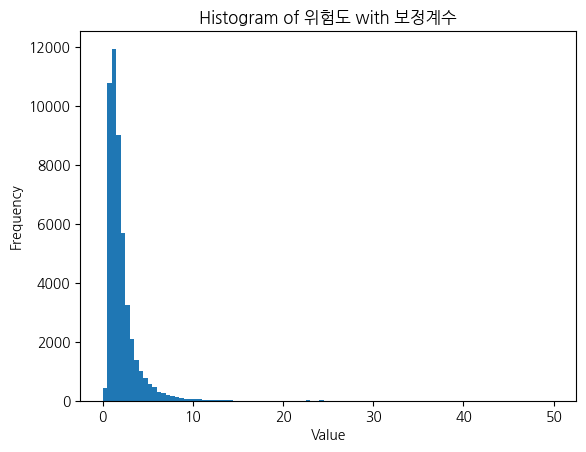

In [60]:
# 히스토그램
plt.hist(df_taxi['위험도-Scaled'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 위험도 with 보정계수')
plt.show()

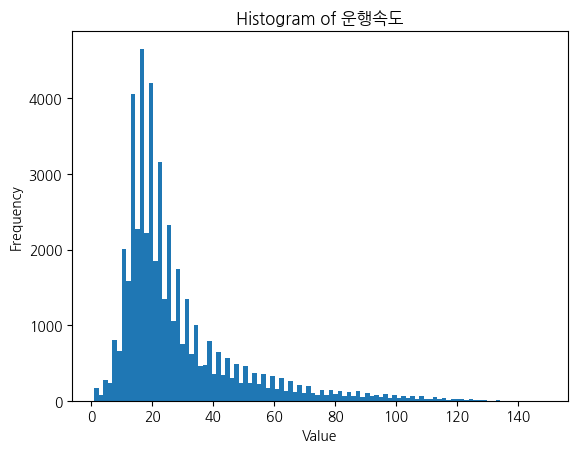

In [61]:
# 히스토그램
plt.hist(df_taxi['운행속도-Scaled'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 운행속도')
plt.show()

4. 보정계수를 사용한 위험도와 운행속도를 곱하여 최종위험도 도출

In [62]:
df_taxi['최종위험도'] = (df_taxi['위험도-Scaled']) * df_taxi['운행속도-Scaled'] 
df_taxi

,요일,월,시간대,동,운행속도,위험도,위도,경도,위험도-Scaled,운행속도-Scaled,최종위험도
0,0,1,0,가정동,24.0,0.494396,37.526332,126.670520,1.107755,24.0,26.586120
1,0,1,0,가좌동,25.0,1.844796,37.494372,126.672601,3.995827,25.0,99.895678
2,0,1,0,간석동,22.0,2.045496,37.460391,126.698042,4.930109,22.0,108.462400
3,0,1,0,갈산동,22.0,1.521596,37.517675,126.727199,3.667391,22.0,80.682603
4,0,1,0,갈현동,45.0,0.763061,37.580800,126.722300,1.045393,45.0,47.042689
...,...,...,...,...,...,...,...,...,...,...,...
48909,0,7,2,테스트동,79.7,3.000000,0.000000,0.000000,3.000000,79.7,239.100000
48910,0,7,2,테스트동,60.0,4.000000,0.000000,0.000000,4.485000,60.0,269.100000
48911,0,7,2,테스트동,89.7,3.000000,0.000000,0.000000,3.000000,89.7,269.100000
48912,0,7,2,테스트동,60.0,8.000000,0.000000,0.000000,8.970000,60.0,538.200000


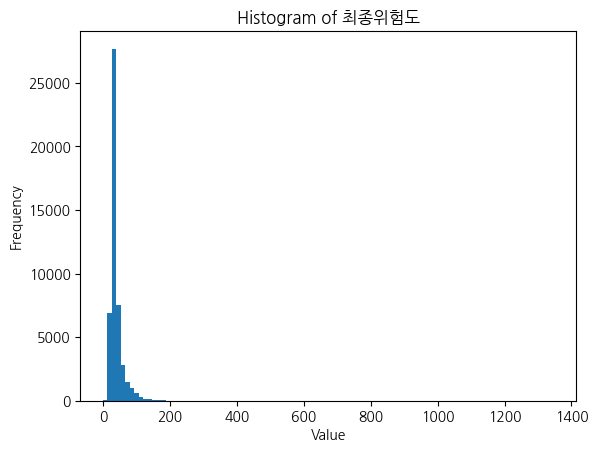

In [63]:
# 히스토그램
plt.hist(df_taxi['최종위험도'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 최종위험도')
plt.show()

# 최종위험도 분포 조절
한 곳에 극단적으로 치우어진 분포를 평활화하기위해서 Log를 적용하여 좁은 범위에서 표현하도록 한다.

In [64]:
min_val = df_taxi[df_taxi['최종위험도'] > 0]['최종위험도'].min()
correc_val = 1 / min_val
correc_val

0.11833767822402527

1. 로그 적용을 위해 최종위험도의 최소값을 1을 기준으로 적용하고, 반올림해두는 처리를 한다.
- 위의 correc_val을 곱하면 최소값이 1부터 시작한다.

In [65]:
df_taxi['최종위험도_로그사전처리'] = (df_taxi['최종위험도'] * correc_val).round(5)
min_value = df_taxi.loc[df_taxi['최종위험도_로그사전처리'] >= 1, '최종위험도_로그사전처리'].min()
df_taxi.loc[df_taxi['최종위험도_로그사전처리'] <= 1, '최종위험도_로그사전처리'] = min_value

2. 로그 적용

In [66]:
df_taxi['최종위험도_Log'] = np.log(df_taxi['최종위험도_로그사전처리'])
df_taxi

,요일,월,시간대,동,운행속도,위험도,위도,경도,위험도-Scaled,운행속도-Scaled,최종위험도,최종위험도_로그사전처리,최종위험도_Log
0,0,1,0,가정동,24.0,0.494396,37.526332,126.670520,1.107755,24.0,26.586120,3.14614,1.146176
1,0,1,0,가좌동,25.0,1.844796,37.494372,126.672601,3.995827,25.0,99.895678,11.82142,2.469913
2,0,1,0,간석동,22.0,2.045496,37.460391,126.698042,4.930109,22.0,108.462400,12.83519,2.552191
3,0,1,0,갈산동,22.0,1.521596,37.517675,126.727199,3.667391,22.0,80.682603,9.54779,2.256310
4,0,1,0,갈현동,45.0,0.763061,37.580800,126.722300,1.045393,45.0,47.042689,5.56692,1.716842
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48909,0,7,2,테스트동,79.7,3.000000,0.000000,0.000000,3.000000,79.7,239.100000,28.29454,3.342669
48910,0,7,2,테스트동,60.0,4.000000,0.000000,0.000000,4.485000,60.0,269.100000,31.84467,3.460870
48911,0,7,2,테스트동,89.7,3.000000,0.000000,0.000000,3.000000,89.7,269.100000,31.84467,3.460870
48912,0,7,2,테스트동,60.0,8.000000,0.000000,0.000000,8.970000,60.0,538.200000,63.68934,4.154017


3. 로그를 적용한 최종위험도를 0~1사이로 스케일링

In [67]:
from sklearn.preprocessing import MinMaxScaler

# B 컬럼 값들을 2차원 배열로 변환
values_to_scale = df_taxi['최종위험도_Log'].values.reshape(-1, 1)

# Min-Max 스케일링 객체 생성
scaler = MinMaxScaler()

# 0~1 사이로 스케일링
scaled_values = scaler.fit_transform(values_to_scale)

# 스케일링된 값으로 B 컬럼 업데이트
df_taxi['최종위험도_Scaled'] = scaled_values.flatten()

4. 데이터 분포 확인

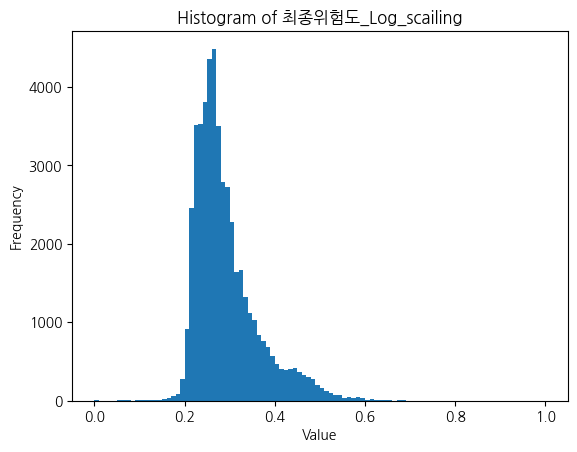

In [68]:
# 히스토그램
plt.hist(df_taxi['최종위험도_Scaled'], bins=100)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of 최종위험도_Log_scailing')
plt.show()

# 시각화 및 분석

In [69]:
import folium

# 각 구간의 임계값 계산
quantiles = np.linspace(0, 1, 10)

# 각 구간의 최소값과 최대값 계산
ranges = []
for i in range(len(quantiles) - 1):
    min_value = df_taxi['최종위험도_Scaled'].quantile(quantiles[i])
    max_value = df_taxi['최종위험도_Scaled'].quantile(quantiles[i+1])
    ranges.append([min_value, max_value])


def get_range_category(value):
    for i, range_values in enumerate(ranges):
        if value >= range_values[0] and value <= range_values[1]:
            return i
    return 0

def geo_poligon_seegak(target):
  df_avg_speed = target.groupby('동')['최종위험도_Scaled', '위도', '경도', '운행속도', '위험도'].mean().reset_index()
  min_speed = df_avg_speed['최종위험도_Scaled'].min()
  max_speed = df_avg_speed['최종위험도_Scaled'].max()
  speed_range = max_speed - min_speed


  # 지도 생성
  m = folium.Map(location=[37.5, 126.75], zoom_start=12)

  colors = ['#0000FF', '#0088FF', '#00FFFF', '#00FF88', '#00FF00', '#88FF00', '#FFFF00', '#FF8800', '#FF0000']
  # 동별 평균 운행속도 시각화
  for _, row in df_avg_speed.iterrows():
      동 = row['동']
      최종위험도 = row['최종위험도_Scaled']
      
      # B에서 해당 동의 위경도 가져오기
      위도 = row['위도']
      경도 = row['경도']
      위험도= row['위험도']
      운행속도= row['운행속도']

      # 운행속도에 따른 마커 색상 계산
      color_index = get_range_category(최종위험도)

      if color_index >= len(colors):
          color_index = len(colors) - 1

      fill_color = colors[color_index]
      
      # CircleMarker 생성하여 지도에 추가
      marker = folium.CircleMarker(
          location=[위도, 경도],
          radius=5,
          color='black',
          fill=True,
          fill_color=fill_color,
          fill_opacity=0.7,
          tooltip=f"동: {동}, 위험도: {위험도}, 운행속도: {운행속도} 최종위험도: {최종위험도}"
      )
      marker.add_to(m)


  legend_html = '''
      <div style="position: fixed; bottom: 50px; left: 50px; background-color: white; border: 2px solid grey; z-index:9999; padding: 10px;">
          <h4>위험도</h4>
          <table>
              <tr><td style="background-color: #FF0000; width: 15px;"></td><td>90%</td></tr>
              <tr><td style="background-color: #FF8800; width: 15px;"></td><td>80%</td></tr>
              <tr><td style="background-color: #FFFF00; width: 15px;"></td><td>70%</td></tr>
              <tr><td style="background-color: #88FF00; width: 15px;"></td><td>60%</td></tr>
              <tr><td style="background-color: #00FF00; width: 15px;"></td><td>50%</td></tr>
              <tr><td style="background-color: #00FF88; width: 15px;"></td><td>40%</td></tr>
              <tr><td style="background-color: #00FFFF; width: 15px;"></td><td>30%</td></tr>
              <tr><td style="background-color: #0088FF; width: 15px;"></td><td>20%</td></tr>
              <tr><td style="background-color: #0000FF; width: 15px;"></td><td>10%</td></tr>
          </table>
      </div>
  '''

  # HTML 형태의 정보를 folium.map에 추가
  m.get_root().html.add_child(folium.Element(legend_html))


  # 지도 출력
  return m

In [70]:
df_tmp = df_taxi[(df_taxi['월'] == 2) & (df_taxi['시간대'] == 1) & (df_taxi['요일'] == 2)]
m = geo_poligon_seegak(df_tmp)
m

<ipython-input-69-066799859621>:21: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_avg_speed = target.groupby('동')['최종위험도_Scaled', '위도', '경도', '운행속도', '위험도'].mean().reset_index()


In [71]:
averages = []

for range_values in ranges:
    # 범위의 최소값과 최대값
    min_value = range_values[0]
    max_value = range_values[1]

    # 조건에 해당하는 행 필터링
    filtered_df = df_taxi[(df_taxi['최종위험도_Scaled'] >= min_value) & (df_taxi['최종위험도_Scaled'] <= max_value)]

    # "운행속도"와 "위험도" 열 추출
    speed = filtered_df['운행속도']
    risk = filtered_df['위험도']

    # 평균 계산
    average_speed = np.mean(speed)
    average_risk = np.mean(risk)

    # 평균을 리스트에 추가
    averages.append([average_speed, average_risk])

# 결과 출력
for i, range_values in enumerate(ranges):
    print("범위 {}: 운행속도 평균={}, 위험도 평균={}".format(i+1, averages[i][0], averages[i][1]))

범위 1: 운행속도 평균=15.686718175128771, 위험도 평균=0.4911152970853702
범위 2: 운행속도 평균=20.978125, 위험도 평균=0.5222273123218144
범위 3: 운행속도 평균=22.58970588235294, 위험도 평균=0.5585437427740821
범위 4: 운행속도 평균=23.62858719646799, 위험도 평균=0.5913240898129595
범위 5: 운행속도 평균=28.774917248988597, 위험도 평균=0.6093372504117807
범위 6: 운행속도 평균=31.946059608703603, 위험도 평균=0.6552156149894578
범위 7: 운행속도 평균=34.97077743061937, 위험도 평균=0.7253511927560373
범위 8: 운행속도 평균=36.87240301526016, 위험도 평균=0.8749521959665512
범위 9: 운행속도 평균=33.901711131554734, 위험도 평균=1.528315370615014


## 상위/하위 최종위험도 확인

In [72]:
# 상위 최종위험도
top_data = df_taxi.nlargest(50, '최종위험도')[['동', '시간대', '요일', '월', '위험도', '운행속도', '최종위험도']]
top_data

,동,시간대,요일,월,위험도,운행속도,최종위험도
27593,운남동,2,5,7,15.662396,86.0,1346.966015
5306,경서동,1,2,2,10.235392,26.0,558.084723
48912,테스트동,2,0,7,8.000000,60.0,538.200000
48913,테스트동,2,0,7,6.000000,89.7,538.200000
26564,구월동,4,3,7,6.069331,15.0,305.894259
1343,운서동,1,2,1,4.770164,45.0,294.080582
6863,연수동,4,4,2,5.581728,18.0,287.598511
20759,중산동,4,0,6,4.721196,38.0,278.668566
48910,테스트동,2,0,7,4.000000,60.0,269.100000
48911,테스트동,2,0,7,3.000000,89.7,269.100000


In [73]:
# 하위 최종위험도
bottom_data = df_taxi.nsmallest(50, '최종위험도')[['위험도', '운행속도', '최종위험도']]
bottom_data

,위험도,운행속도,최종위험도
40844,0.000000,63.0,0.000000
37006,0.129956,54.0,8.450394
37039,0.129956,57.0,8.596595
42314,0.144229,42.0,8.729438
42901,0.170902,17.0,8.741618
42868,0.170902,31.0,9.638852
37044,0.176992,28.0,9.783221
41155,0.146580,60.0,9.861159
48558,0.173114,36.0,10.088240
46872,0.191044,27.0,10.488327


## 비슷한 최종위험도 데이터들 확인

In [74]:
# '최종위험도'가 200에서 ±10의 오차를 가지는 행을 선택합니다.
selected_rows = df_taxi[(df_taxi['최종위험도'] >= 150) & (df_taxi['최종위험도'] <= 160)]

# 상위 50개의 행을 선택합니다.
top_50_rows = selected_rows.head(50)

top_50_rows

,요일,월,시간대,동,운행속도,위험도,위도,경도,위험도-Scaled,운행속도-Scaled,최종위험도,최종위험도_로그사전처리,최종위험도_Log,최종위험도_Scaled
19,0,1,0,남촌동,33.0,2.734796,37.424100,126.712700,4.736169,33.0,156.293564,18.49542,2.917523,0.575290
130,0,1,1,남북동,88.0,1.805948,37.450260,126.413012,1.805948,88.0,158.923382,18.80662,2.934209,0.578580
613,1,1,0,부평동,16.0,2.960428,37.494216,126.720071,9.394732,16.0,150.315708,17.78801,2.878525,0.567600
673,1,1,0,하야동,93.0,1.717293,37.580700,126.785300,1.717293,93.0,159.708290,18.89951,2.939136,0.579552
1150,2,1,0,가좌동,28.0,2.734796,37.494372,126.672601,5.398779,28.0,151.165823,17.88861,2.884164,0.568712
3372,5,1,4,논현동,23.0,2.900972,37.405755,126.729308,6.735299,23.0,154.911880,18.33191,2.908643,0.573539
4704,1,2,0,중산동,104.0,1.487596,37.497400,126.561600,1.487596,104.0,154.709935,18.30801,2.907339,0.573282
4867,1,2,2,도화동,17.0,2.987664,37.460936,126.673892,8.989352,17.0,152.818989,18.08424,2.895041,0.570857
6902,5,2,0,가좌동,32.0,2.740496,37.494372,126.672601,4.862239,32.0,155.591634,18.41235,2.913022,0.574402
9649,2,3,4,구월동,14.0,3.151824,37.447651,126.712492,11.262141,14.0,157.669972,18.65830,2.926291,0.577019


## 보정계수 검증을 위한 테스트데이터셋 확인
- 유동차량이 2배 == 위험도 1 증가 검증

In [75]:
selected_rows = df_taxi[(df_taxi['동'] == '테스트동')]


top_50_rows = selected_rows.head(50)

top_50_rows

,요일,월,시간대,동,운행속도,위험도,위도,경도,위험도-Scaled,운행속도-Scaled,최종위험도,최종위험도_로그사전처리,최종위험도_Log,최종위험도_Scaled
48906,0,6,1,테스트동,20.0,4.0,0.0,0.0,10.455000,20.0,209.1000,24.74441,3.208600,0.632686
48907,0,7,2,테스트동,69.7,3.0,0.0,0.0,3.052188,69.7,212.7375,25.17486,3.225846,0.636086
48908,0,7,2,테스트동,40.0,4.0,0.0,0.0,5.977500,40.0,239.1000,28.29454,3.342669,0.659122
48909,0,7,2,테스트동,79.7,3.0,0.0,0.0,3.000000,79.7,239.1000,28.29454,3.342669,0.659122
48910,0,7,2,테스트동,60.0,4.0,0.0,0.0,4.485000,60.0,269.1000,31.84467,3.460870,0.682429
48911,0,7,2,테스트동,89.7,3.0,0.0,0.0,3.000000,89.7,269.1000,31.84467,3.460870,0.682429
48912,0,7,2,테스트동,60.0,8.0,0.0,0.0,8.970000,60.0,538.2000,63.68934,4.154017,0.819107
48913,0,7,2,테스트동,89.7,6.0,0.0,0.0,6.000000,89.7,538.2000,63.68934,4.154017,0.819107


## 위험도, 운행속도별 상위,하위 100건 확인

In [76]:
top_100_data = df_taxi.nlargest(100, '위험도')[['동', '시간대', '요일', '월', '위험도', '운행속도', '최종위험도']]
top_100_data

,동,시간대,요일,월,위험도,운행속도,최종위험도
27593,운남동,2,5,7,15.662396,86.0,1346.966015
5306,경서동,1,2,2,10.235392,26.0,558.084723
48912,테스트동,2,0,7,8.000000,60.0,538.200000
26564,구월동,4,3,7,6.069331,15.0,305.894259
48913,테스트동,2,0,7,6.000000,89.7,538.200000
...,...,...,...,...,...,...,...
30125,구월동,4,2,8,3.265572,15.0,164.584805
16054,주안동,4,6,4,3.245892,15.0,163.592933
27758,구월동,4,5,7,3.241324,16.0,164.578202
38151,도화동,2,2,10,3.235928,17.0,165.517693


In [77]:
bottom_100_data = df_taxi.nsmallest(100, '위험도')[['동', '시간대', '요일', '월', '위험도', '운행속도', '최종위험도']]
bottom_100_data

,동,시간대,요일,월,위험도,운행속도,최종위험도
40844,덕교동,0,0,11,0.000000,63.0,0.000000
37006,양사면,2,0,10,0.129956,54.0,8.450394
37039,하점면,2,0,10,0.129956,57.0,8.596595
42314,하점면,2,2,11,0.144229,42.0,8.729438
41155,하점면,2,0,11,0.146580,60.0,9.861159
...,...,...,...,...,...,...,...
21633,내가면,2,2,6,0.336456,4.0,15.569489
1807,운북동,0,3,1,0.336658,106.0,35.685746
22288,하점면,2,3,6,0.336877,23.0,17.989217
18767,내가면,3,4,5,0.337588,32.0,19.166578


In [78]:
top_100_data = df_taxi.nlargest(100, '운행속도')[['동', '시간대', '요일', '월', '위험도', '운행속도', '최종위험도']]
top_100_data

,동,시간대,요일,월,위험도,운행속도,최종위험도
11046,선주지동,1,5,3,0.637305,149.0,94.958481
3501,목상동,0,6,1,0.909958,143.0,130.124013
3489,다남동,0,6,1,0.604141,139.0,83.975659
11016,노오지동,1,5,3,0.597946,137.0,81.918579
12417,목상동,3,0,4,0.588503,134.0,78.859378
...,...,...,...,...,...,...,...
36307,장기동,1,6,9,0.604396,120.0,72.527463
36684,평동,4,6,9,0.489213,120.0,58.705561
37732,운북동,3,1,10,0.507996,120.0,60.959463
37908,다남동,0,2,10,0.558077,120.0,66.969282


In [79]:
bottom_100_data = df_taxi.nsmallest(100, '운행속도')[['동', '시간대', '요일', '월', '위험도', '운행속도', '최종위험도']]
bottom_100_data

,동,시간대,요일,월,위험도,운행속도,최종위험도
963,북성동3가,3,1,1,0.503448,1.0,22.730691
2119,북성동3가,3,3,1,0.520880,1.0,23.517731
3561,중앙동3가,0,6,1,0.578967,1.0,26.140364
3800,항동1가,2,6,1,0.519743,1.0,23.466387
4423,북성동3가,3,0,2,0.551703,1.0,24.909390
...,...,...,...,...,...,...,...
6718,북성동3가,3,4,2,0.475701,2.0,21.656283
7941,항동1가,3,6,2,0.495981,2.0,22.579517
9238,관동3가,0,2,3,0.549402,2.0,25.011538
9433,관동3가,2,2,3,0.574342,2.0,26.146918
